In [55]:
import re
import string
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from textblob import TextBlob
from textblob import Word

# read and concat data

In [2]:
data1 = pd.read_excel('investing_comments_cleaned.xls', header = None)
data2 = pd.read_excel('options_comments_cleaned.xls', header = None)
data3 = pd.read_excel('overall_comments_cleaned.xls', header = None)
data4 = pd.read_excel('SecurityAnalysis_comments_cleaned.xls', header = None)
data5 = pd.read_excel('stocks_comments_cleaned.xls', header = None)
data6 = pd.read_excel('wsb_comments_cleaned.xls', header = None)
data7 = pd.read_excel('supplement_comments_cleaned.xls', header = None)

In [3]:
data = pd.concat([data1,data2,data3,data4,data5,data6,data7], ignore_index=True)

In [4]:
data.columns = ['text', 'sentiment']

In [5]:
data.head()

,text,sentiment
0,Why doesn’t amazon go up? I have 30k in it,0
1,RIP my Amazon stock,0
2,Nah Sell the ETFs and YOLO your portfolio on $...,0
3,Did Amazon give any reason why it gave lower g...,0
4,The amazon comment concerns me from an economi...,0


In [6]:
data.describe()

,sentiment
count,1762.000000
mean,0.456867
std,0.498278
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# visualization

In [7]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data_pos = data[data['sentiment'] == 1]
data_pos = data_pos['text']
data_neg = data[data['sentiment'] == 0]
data_neg = data_neg['text']

Positive words


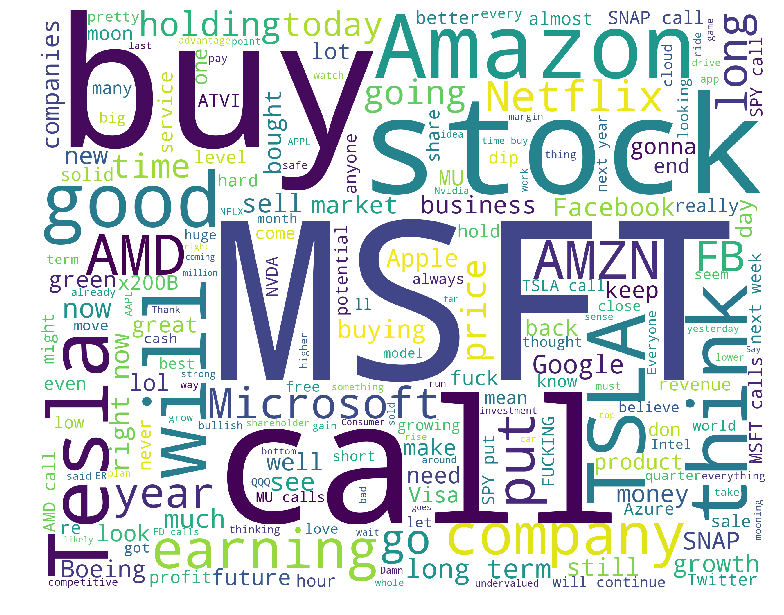

Negative words


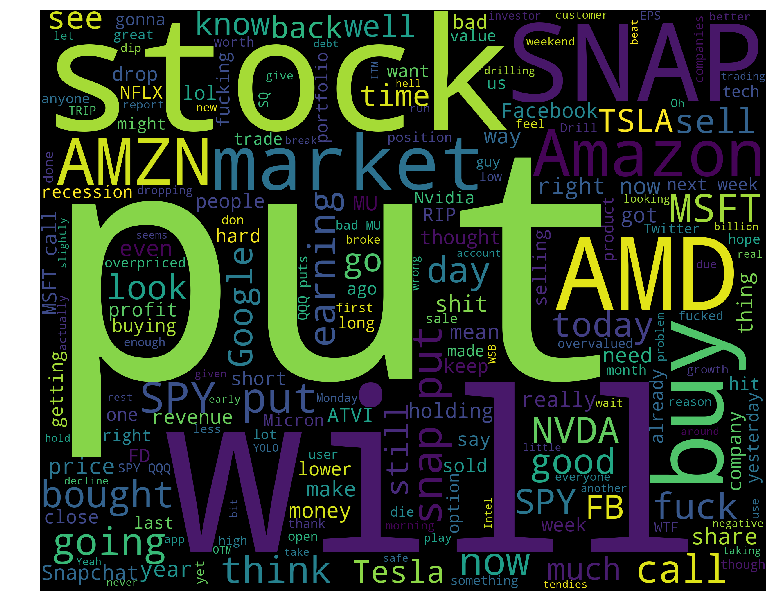

In [9]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and 'www' not in word
                                and not word.startswith('#')
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(data_pos,'white')
print("Negative words")
wordcloud_draw(data_neg)

# read stock list and build a list of stopwords

In [10]:
stock_list = pd.read_csv('stocks_cleaned.csv')

In [11]:
stock_list.columns = ['ticker', 'company']

In [12]:
stock_list.head()

,ticker,company
0,NVAX,Novavax
1,SIRI,Sirius XM
2,QQQ,Invesco QQQ
3,AAPL,Apple
4,MSFT,Microsoft


In [13]:
def build_stoplist(df):
    stoplist = set()
    for index, row in df.iterrows():
        stoplist.add(row.ticker.lower())
        stoplist.update(row.company.lower().split())
    return stoplist

In [14]:
stock_stop = build_stoplist(stock_list)

In [15]:
len(stock_stop)

1336

# text preprocess

In [16]:
def pre_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

In [17]:
def is_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

In [18]:
# preprocess a single line of text
st = PorterStemmer()

def pre_text(text):
    processed_text = []
    
    text = text.lower()
    
    # remove link
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', text)
    
    # remove 2 more dots
    text = re.sub(r'\.{2,}', ' ', text)

    text = text.strip(' >"\'')
    
    words = text.split()
    
    # remove stopwords
    words = [word for word in words if word not in stock_stop]
    
    # stemming
    words = [st.stem(word) for word in words]
    
    # lemmatizing
    words = [Word(word).lemmatize() for word in words]
    
    # remove too long or too short word
    for word in words:
        word = pre_word(word)
        if is_word(word) and len(word) >= 2 and len(word) <= 10:
            processed_text.append(word)
            
    # remove punctuation
    new_text = ' '.join(processed_text)
    new_text =  re.sub(r"[^\w\s]", "", new_text)
    return new_text

In [19]:
data.text = data.text.apply(pre_text)

In [20]:
data.head()

,text,sentiment
0,whi go up have in,0
1,rip my stock,0
2,nah sell etf yolo your portfolio spi put for n...,0
3,did give ani reason whi gave lower guidanc sal...,0
4,comment concern me from econom standpoint thou...,0


Positive words


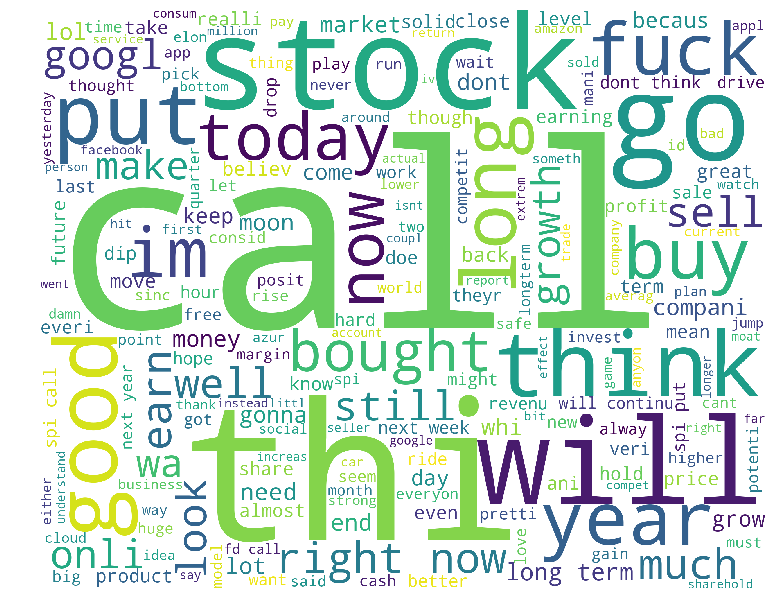

Negative words


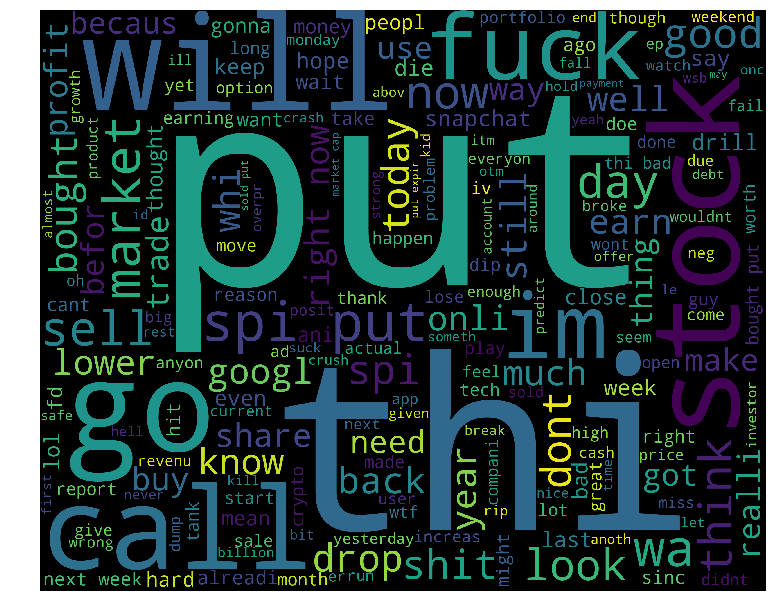

In [21]:
data_pos1 = data[data['sentiment'] == 1]
data_pos1 = data_pos1['text']
data_neg1 = data[data['sentiment'] == 0]
data_neg1 = data_neg1['text']

print("Positive words")
wordcloud_draw(data_pos1,'white')
print("Negative words")
wordcloud_draw(data_neg1)

### Bag-of-words representation
#### 1. Count Vector
#### 2. TF-IDF

#### We use cross validation so we do not split train and test

In [22]:
all_words = []
for i in data.text:
    words = word_tokenize(i)
    for word in words:
        all_words.append(word)

labels = []
for i in data.sentiment:
    labels.append(i)
y = pd.Series(labels)

#### 1. Count Vector

In [23]:
countvector = CountVectorizer(input=all_words,lowercase=True, min_df=2, ngram_range=(1, 1))

count_matrix = countvector.fit_transform(data.text)

feature_names = countvector.get_feature_names()

df_count = pd.DataFrame(count_matrix.toarray(), columns = feature_names)

df_count.shape

(1762, 2342)

In [24]:
df_count.tail()

,aaa,aaaaaand,aaaargh,aapl,abandon,abl,about,abov,absurd,accelerate,...,young,your,yourself,yr,ytd,yuorself,zero,zoomer,zuck,zuckerberg
1757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. TF-IDF

In [25]:
tfidf_vectorizer = TfidfVectorizer(input=all_words,lowercase=True, min_df=2, ngram_range=(1, 1))

tfidf_matrix = tfidf_vectorizer.fit_transform(data.text)

feature_names = tfidf_vectorizer.get_feature_names()

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)

df_tfidf.shape

(1762, 2342)

In [26]:
df_tfidf.tail()

,aaa,aaaaaand,aaaargh,aapl,abandon,abl,about,abov,absurd,accelerate,...,young,your,yourself,yr,ytd,yuorself,zero,zoomer,zuck,zuckerberg
1757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# then we use bag of words as features, sentiment as labels, do cross validation in NB and Logistic Regression

### Count Vector

In [28]:
# 1) NB
nbmodel = MultinomialNB()

In [29]:
# 10-fold CV
scores1 = cross_val_score(nbmodel , df_count, y, cv=10)

In [30]:
print(scores1)
print(scores1.mean())

[0.89265537 0.76271186 0.85310734 0.85875706 0.91525424 0.74431818
 0.89204545 0.77714286 0.86857143 0.70857143]
0.8273135226355566


In [31]:
# 2) Logistic Regression
logmodel = LogisticRegression()

In [32]:
# 10-fold CV
scores2 = cross_val_score(logmodel , df_count, y, cv=10)

In [33]:
print(scores2)
print(scores2.mean())

[0.95480226 0.88135593 0.93220339 0.93220339 0.96045198 0.78977273
 0.94318182 0.88       0.93142857 0.76571429]
0.8971114351749943


In [56]:
# 3) Ridge Regression
rgmodel = Ridge()

In [58]:
# 10-fold CV
scores3 = cross_val_score(rgmodel , df_count, y, cv=10)

In [59]:
print(scores3)
print(scores3.mean())

[ 0.87921613  0.81289784  0.84392929  0.8260898   0.87003102 -0.57821518
  0.82402028  0.83292478  0.85347401  0.32767382]
0.6492041789856058


### TF-IDF

In [34]:
# 1) NB
scores1 = cross_val_score(nbmodel, df_tfidf, y, cv=10)

In [35]:
print(scores1)
print(scores1.mean())

[0.8700565  0.72316384 0.88700565 0.8700565  0.91525424 0.77272727
 0.86363636 0.77142857 0.89714286 0.73142857]
0.8301900359527478


In [36]:
# 2) Logistic Regression
logmodel = LogisticRegression()

In [37]:
# 10-fold CV
scores2 = cross_val_score(logmodel, df_tfidf, y, cv=10)

In [38]:
print(scores2)
print(scores2.mean())

[0.85310734 0.75141243 0.86440678 0.89830508 0.88700565 0.73295455
 0.85227273 0.79428571 0.86857143 0.76571429]
0.8268035989434294


In [60]:
# 3) Ridge Regression
scores3 = cross_val_score(rgmodel, df_tfidf, y, cv=10)

In [61]:
print(scores3)
print(scores3.mean())

[0.65232401 0.55654045 0.68606329 0.73456493 0.62815707 0.53624203
 0.57847048 0.61915736 0.73986978 0.36558848]
0.6096977876446946


# NLTK + NaiveBayesClassifier

In [39]:
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

In [40]:
data.sentiment = data.sentiment.map(lambda x:'Positive' if x==1 else 'Negative')

In [41]:
data.head()

,text,sentiment
0,whi go up have in,Negative
1,rip my stock,Negative
2,nah sell etf yolo your portfolio spi put for n...,Negative
3,did give ani reason whi gave lower guidanc sal...,Negative
4,comment concern me from econom standpoint thou...,Negative


In [42]:
texts = []
stopwords_set = set(stopwords.words("english"))
for index, row in data.iterrows():
    words_filtered = [e for e in row.text.split() if len(e) >= 3]
    words_without_stopwords = [word for word in words_filtered if not word in stopwords_set]
    texts.append((words_without_stopwords, row.sentiment))

In [43]:
train, test = train_test_split(texts,test_size = 0.2)

In [44]:
def get_words_in_texts(texts):
    all_words = []
    for (words, sentiment) in texts:
        all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_texts(train))

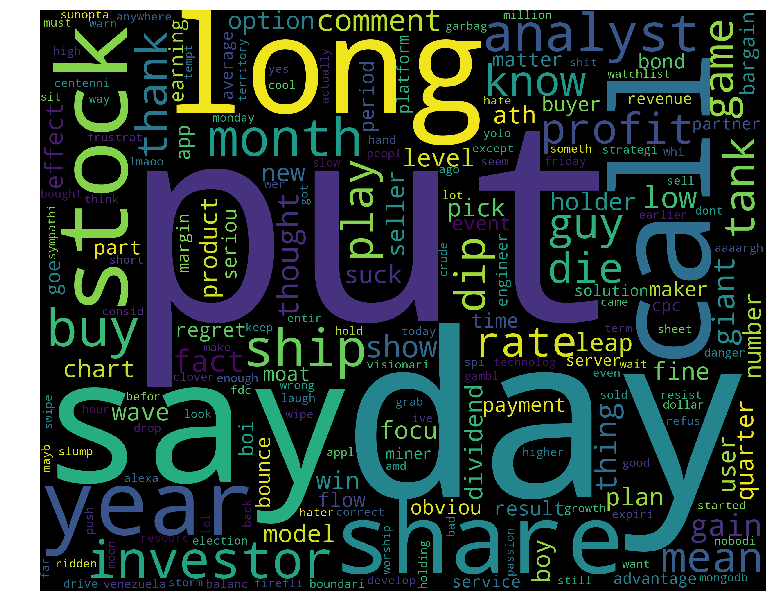

In [45]:
wordcloud_draw(word_features)

In [46]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [47]:
training_set = nltk.classify.apply_features(extract_features,train)

In [48]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [49]:
print(classifier.show_most_informative_features(10))

Most Informative Features
           contains(rip) = True           Negati : Positi =     11.2 : 1.0
          contains(moon) = True           Positi : Negati =      8.5 : 1.0
         contains(cloud) = True           Positi : Negati =      8.5 : 1.0
          contains(grow) = True           Positi : Negati =      8.5 : 1.0
           contains(use) = True           Negati : Positi =      8.0 : 1.0
          contains(elon) = True           Positi : Negati =      7.7 : 1.0
        contains(higher) = True           Positi : Negati =      6.9 : 1.0
          contains(tank) = True           Negati : Positi =      6.9 : 1.0
        contains(future) = True           Positi : Negati =      6.6 : 1.0
         contains(solid) = True           Positi : Negati =      6.6 : 1.0
None


In [50]:
test_pos = [words for words,sentiment in test if sentiment == 'Positive']
test_neg = [words for words,sentiment in test if sentiment == 'Negative']

In [51]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))   

[Negative]: 184/171 
[Positive]: 169/130 


In [52]:
print(round((neg_cnt+pos_cnt)/(len(test_neg)+len(test_pos))*100),'%')

85 %
